In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,8)

In [4]:
elevation = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(roi)
def maskSR(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = image.get('SOLAR_AZIMUTH_ANGLE')
    zenith = image.get('SOLAR_ZENITH_ANGLE')
    return image.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True))
# 图像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

# l5+l7+l8

##  定义函数

In [5]:
def detect_outlier(image):
    a = image.clip(roi).lt(0)
    max = a.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14})
    number = ee.Number(max.get('B2')).add(ee.Number(max.get('B3'))).add(ee.Number(max.get('B4'))).add(ee.Number(max.get('B5'))).add(ee.Number(max.get('B6'))).add(ee.Number(max.get('B7')))
    return image.set({'outlier': number}).set({'outlier_B2': max.get('B2')}).set({'outlier_B3': max.get('B3')}).set({'outlier_B4': max.get('B4')}).set({'outlier_B5': max.get('B5')}).set({'outlier_B6': max.get('B6')}).set({'outlier_B7': max.get('B7')})

In [6]:

# def detect_outlier(image):
#     a = image.clip(roi).lt(0)
#     max = a.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14})
#     number = max.get('pixel_qa')
#     return image.set({'outlier': number})

In [7]:
def outlier_images(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    l7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    l5_bands = l5.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    l7_bands = l7.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    l8_bands = l8.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    l5_images = l5_bands.map(detect_outlier).filter(ee.Filter.gt('outlier',0))
    l7_images = l7_bands.map(detect_outlier).filter(ee.Filter.gt('outlier',0))  
    l8_images = l8_bands.map(detect_outlier).filter(ee.Filter.gt('outlier',0))   
    return l5_images.size().add(l7_images.size()).add(l8_images.size())

def normal_images(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    l7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    l5_bands = l5.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    l7_bands = l7.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    l8_bands = l8.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa'])
    l5_images = l5_bands.map(detect_outlier).filter(ee.Filter.lte('outlier',0))
    l7_images = l7_bands.map(detect_outlier).filter(ee.Filter.lte('outlier',0))  
    l8_images = l8_bands.map(detect_outlier).filter(ee.Filter.lte('outlier',0))   
    return l5_images.size().add(l7_images.size()).add(l8_images.size())

def l578(year):
    start = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-01-01'))
    end = ee.Algorithms.String(ee.Number(year).int()).cat(ee.String('-12-31'))
    l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    l7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate(start, end)
    return l5.size().add(l7.size()).add(l8.size())

## 计算

In [ ]:
import numpy as np
for i in np.arange(1999,2021,1):
    print(outlier_images(int(i)).getInfo())

import numpy as np
for i in np.arange(1999,2021,1):
    print(normal_images(int(i)).getInfo())

import numpy as np
for i in np.arange(1999,2021,1):
    print(l578(int(i)).getInfo())

In [9]:
a = ee.List.sequence(2000,2020,1)
outlier = a.map(outlier_images).getInfo()
print(outlier)

normal = a.map(normal_images).getInfo()
print(normal)

l8_images = a.map(l578).getInfo()
print(l8_images)

EEException: Too many concurrent aggregations.

In [ ]:
# [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# [70, 89, 81, 79, 93, 76, 80, 75, 80, 82, 69, 73, 33, 97, 87, 110, 109, 106, 104, 97, 85]
# [70, 89, 81, 79, 93, 76, 80, 75, 80, 82, 69, 73, 33, 97, 87, 110, 109, 106, 104, 97, 85]

## 绘图

In [11]:
normal = [147, 157, 143, 126, 151, 134, 136, 149, 120, 118, 112, 104, 62, 105, 142, 139, 137, 133, 137, 150, 118]
outlier = [35, 33, 21, 16, 27, 8, 17, 17, 22, 22, 19, 25, 12, 15, 24, 18, 11, 29, 14, 26, 21]

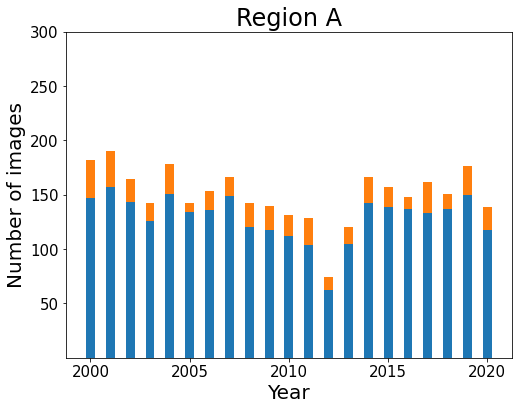

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
x = np.arange(2000,2021)
plt.figure(figsize=(8, 6))
plt.bar(x, normal, width=0.45,align="center",label="normal images")
plt.bar(x, outlier, width=0.45, align="center", bottom=normal, label="abnormal images")
# plt.bar(x, l8, width=0.45, align="center", bottom=l7, label="Landsat8")

plt.ylim(0,300)
plt.xlabel("Year",size=20)
plt.ylabel("Number of images",size=20)
plt.tick_params(labelsize=15)
plt.xticks([2000,2005,2010,2015,2020])
plt.yticks([50,100,150,200,250,300])
# plt.legend(prop={'size':24},markerscale=20)
plt.title('Region A',size=24)
plt.show()

In [ ]:
# region a 
[147, 157, 143, 126, 151, 134, 136, 149, 120, 118, 112, 104, 62, 105, 142, 139, 137, 133, 137, 150, 118]
[35, 33, 21, 16, 27, 8, 17, 17, 22, 22, 19, 25, 12, 15, 24, 18, 11, 29, 14, 26, 21]
[182, 190, 164, 142, 178, 142, 153, 166, 142, 140, 131, 129, 74, 120, 166, 157, 148, 162, 151, 176, 139]

# region b
[138, 163, 147, 116, 151, 132, 134, 124, 102, 123, 113, 102, 59, 135, 166, 143, 153, 180, 187, 162, 184]
[67, 71, 44, 48, 59, 62, 68, 62, 81, 67, 62, 72, 46, 63, 71, 80, 72, 46, 56, 56, 35]
[205, 234, 191, 164, 210, 194, 202, 186, 183, 190, 175, 174, 105, 198, 237, 223, 225, 226, 243, 218, 219]

# region c
[58, 81, 75, 74, 91, 72, 69, 62, 75, 70, 58, 63, 28, 81, 66, 80, 90, 85, 92, 91, 76]
[12, 8, 6, 5, 2, 4, 11, 13, 5, 12, 11, 10, 5, 16, 21, 30, 19, 21, 12, 6, 9]
[70, 89, 81, 79, 93, 76, 80, 75, 80, 82, 69, 73, 33, 97, 87, 110, 109, 106, 104, 97, 85]

# region d
[108, 100, 91, 113, 156, 111, 110, 107, 119, 133, 70, 94, 33, 100, 114, 112, 107, 122, 120, 122, 130]
[33, 25, 20, 10, 17, 11, 7, 13, 18, 19, 19, 26, 18, 11, 37, 41, 37, 42, 45, 32, 30]
[141, 125, 111, 123, 173, 122, 117, 120, 137, 152, 89, 120, 51, 111, 151, 153, 144, 164, 165, 154, 160]

# region e
[114, 137, 132, 136, 168, 148, 147, 134, 111, 163, 159, 114, 64, 171, 213, 231, 219, 214, 229, 222, 222]
[30, 47, 19, 16, 24, 15, 21, 12, 18, 17, 21, 28, 24, 18, 32, 28, 27, 30, 31, 18, 22]
[144, 184, 151, 152, 192, 163, 168, 146, 129, 180, 180, 142, 88, 189, 245, 259, 246, 244, 260, 240, 244]

In [ ]:
def detect_outlier(image):
    a = image.clip(roi).lt(0)
    max = a.reduceRegion(**{'reducer': ee.Reducer.max(),'geometry': roi,'scale': 30,'maxPixels': 1e14})
    number = ee.Number(max.get('B2')).add(ee.Number(max.get('B3'))).add(ee.Number(max.get('B4'))).add(ee.Number(max.get('B5'))).add(ee.Number(max.get('B6'))).add(ee.Number(max.get('B7')))
    return image.set({'outlier': number})

# 定义参数
year = '2000'
startDate = year + '-01-01'
endDate = year + '-12-31'

l8 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi) \
       .filterDate(startDate, endDate)

a = l8.map(detect_outlier)
print(l8.size().getInfo())
print(a.filter(ee.Filter.gt('outlier',0)).size().getInfo())
print(a.filter(ee.Filter.lte('outlier',0)).size().getInfo())
print(a.aggregate_array('outlier').getInfo())
print(a.filter(ee.Filter.gt('outlier',0)).first().getInfo())